# Bike sharing LSTM
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = pd.read_csv("london_bs.csv")
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [26]:
col = ['t1','t2','hum','wind_speed','weather_code','cnt',]
input_extracted = df[col].values

Text(0, 0.5, 't1')

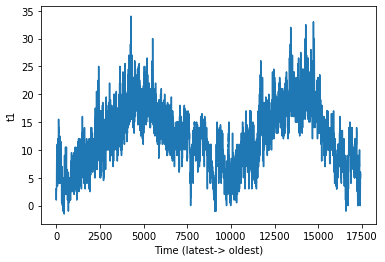

In [27]:
t1 = input_extracted[:,0]
plt.plot(t1)
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("t1")

Text(0, 0.5, 'cnt')

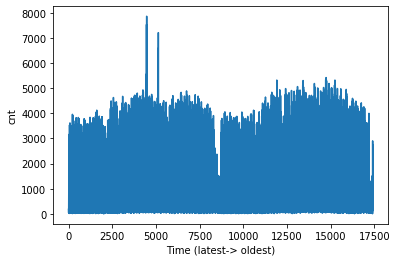

In [28]:
cnt = input_extracted[:,5]
plt.plot(cnt)
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("cnt")

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
#scaled_input = scaler.fit_transform(input_extracted)
scaled_input = input_extracted

In [30]:
scaled_input

array([[  3. ,   2. ,  93. ,   6. ,   3. , 182. ],
       [  3. ,   2.5,  93. ,   5. ,   1. , 138. ],
       [  2.5,   2.5,  96.5,   0. ,   1. , 134. ],
       ...,
       [  5.5,   1.5,  78.5,  24. ,   4. , 337. ],
       [  5.5,   1.5,  76. ,  23. ,   4. , 224. ],
       [  5. ,   1. ,  76. ,  22. ,   2. , 139. ]])

In [31]:
# Number of time steps (days here) to look in the past
lookback = 50
ts_dim = len(col) # Number of variables in the input

# 30% of the latest data is used as a training set
test_size=int(.3 * len(scaled_input))

X = [] # lists of 50 last array([[volume,average]]) for each element of scaled_input
y = [] # the average for each step (starts from look back)


for i in range(len(scaled_input) - lookback - 1):
    t = []
    for j in range(0,lookback):
        t.append(scaled_input[[(i+j)]]) # batch of 50 array([[volume,average]]) for current step
    X.append(t)
    y.append(scaled_input[i + lookback, 1]) 

At each step, y contains the target value and X contains the 50 last features and target. 

y has a size of number of step - lookback - 1

X has a the same size but each element of X has a size equal to lookback

In [32]:
X, y = np.array(X), np.array(y)
X_test = X[:test_size + lookback] 

X = X.reshape(X.shape[0],lookback, ts_dim) 
X_test = X_test.reshape(X_test.shape[0],lookback, ts_dim) 

print(X.shape)
print(X_test.shape)

(17363, 50, 6)
(5274, 50, 6)


In [33]:
from keras import Sequential
from keras.layers import Dense, LSTM

In [34]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],ts_dim)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            4440      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 19,111
Trainable params: 19,111
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
17363/17363 [==============================] - 82s 5ms/step - loss: 38.2592
Epoch 2/10
17363/17363 [==============================] - 74s 4ms/step - loss: 6.1579
Epoch 3/10
17363/17363 [==============================] - 74s 4ms/step - loss: 3.4493
Epoch 4/10
17363/17363 [==============================] - 73s 4ms/step - loss: 2.6296
Epoch 5/10
17363/17363 [==============================] - 74s 4ms/step - loss: 2.3395
Epoch 6/10
17363/17363 [==============================] - 73s 4ms/step - loss: 2.1031
Epoch 7/10
17363/17363 [==============================] - 74s 4ms/step - loss: 1.8553
Epoch 8/10
17363/17363 [==============================] - 73s 4ms/step - loss: 1.6290
Epoch 9/10
17363/17363 [==============================] - 73s 4ms/step - loss: 1.5505
Epoch 10/10
17363/17363 [==============================] - 73s 4ms/step - loss: 1.5155


In [37]:
predicted_value = model.predict(X_test)
predicted_value.shape

(5274, 1)

(0, 3000)

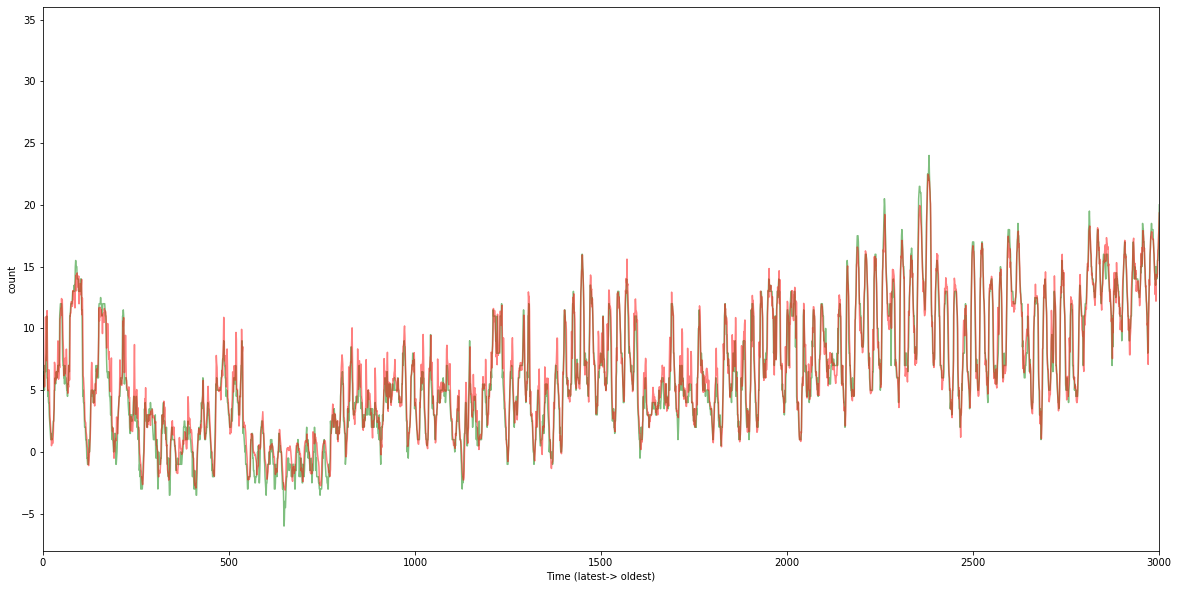

In [42]:
plt.plot(scaled_input[lookback:test_size+(2*lookback),1], color='green',alpha=0.5)
plt.plot(predicted_value, color= 'red', alpha=0.5)
plt.gcf().set_size_inches(20, 10)
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("count")
plt.xlim(0,3000)